<a href="https://colab.research.google.com/github/Battisaco/Hotel-Booking-Cancellation/blob/main/Hotel_booking_demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Olá!

Esse notebook apresenta os passos tomados para o projetos de dados em cima do dataset de Hotel booking.
-------------------------------------------------------------------------------


Esse trabalho teve uma aproximação diferente para o problema, foi percebido que havia valor em separar o dataset em dois, e fazer um modelo para cada caso.
-------------------------------------------------------------------------------
 ------------------------------------------------------------------------------

O objetivo não foi de encontrar os melhore resultados possiveis, por isso as etapas de cross-validation, foi cortada na parte de modelagem por demorar a rodar e não haver disponilização de uma GPU. Para tanto, os algoritmos testados foram montados com seus parametros default/

Nele você encontratará 

*   Os passos da analise exploratória de dados, que conta com limpeza de dados, feature engeneering, uma explicação da separação dos tipos de hotéis, uma analise dos tipos de clientes e seu comportamento

*   Uma sessão de modelagem para hotéis de Resort e outra para hotéis de cida.

*   Os resultado dos testes de algoritmos.

Valem lembrar que essa notebook é um compilado inteiro, no Github tbm está disponibilizado os modelos salvos, um script para treinamento, outro para predição, os dados limpos e os arquivos para deploy. 




# Analise primária / Importação

Nessa etapa, foram feitas importações e explorações como info, describe, counts.
De maneira geral primeiro contato com o dataset

In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')


display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


In [2]:
def figures_to_html(figs, filename="dashboard.html"):
    with open(filename, 'w') as dashboard:
        dashboard.write("<html><head></head><body>" + "\n")
        for fig in figs:
            inner_html = fig.to_html().split('<body>')[1].split('</body>')[0]
            dashboard.write(inner_html)
        dashboard.write("</body></html>" + "\n")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Desktop
'''
path = 'C:/Users/Arthur/Desktop/Hurb'
data = pd.read_csv(path+'/hotel_bookings.csv')
'''

#Colab
data = pd.read_csv('/content/drive/MyDrive/Hurb/Data/Raw_data/hotel_bookings.csv')

In [5]:
data.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [6]:
data['is_canceled'].value_counts()

0    75166
1    44224
Name: is_canceled, dtype: int64

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [8]:
data.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


# EDA

## Limpezas rapidas

In [9]:
data['is_canceled'] = data['is_canceled'].astype(str)
data['arrival_date_year'] = data['arrival_date_year'].astype(str)
data['is_canceled'].value_counts()

0    75166
1    44224
Name: is_canceled, dtype: int64

Tirada das colunas "company" ,'country', '' pois: 
* 'company' está com um grande numero de variaveis faltando, o que segundo o paper dos dados significa que não veio de uma empresa como "não aplicavel", ainda assim muitos dados faltantes.
* 'county', pois, alem da maioria ser de portugal ou paises europeus, como mencionado no artigo, os dados cancelados sempre apresentavam serem de portugueses, pois o dado só era alterado no momento do Check-in
* 'reservation_status' tem praticamente a mesma informação que o target, porem com a adição de "No-show", ou seja, a pessoa não apareceu, o que vou considerar como um cancelamento.


In [10]:
data = data.drop(columns=['country','company','reservation_status','reservation_status_date'])

## Analises e Perguntas de negócios

### Estudo dos dados temporais

É interessante ver como é a distribuição de cancelamentos diante dos meses, comparando de ano a ano.

Uma das hipóteses levantadas é a possibilidade de não utilizar os anos, e considerar apenas os meses, pois, levando em consideração as possiveis temporadas, eles podem afetar nos cancelamentos

In [11]:
years = data['arrival_date_year'].unique()
fig = go.Figure(data = [
    go.Bar(x=years,
        y=[np.round(a/b*100,2) for a,b in zip(data[data['is_canceled'] == '0']['arrival_date_year'].value_counts(),data['arrival_date_year'].value_counts())],
        text=[np.round(a/b*100,2) for a,b in zip(data[data['is_canceled'] == '0']['arrival_date_year'].value_counts(),data['arrival_date_year'].value_counts())],
        name='Not cancelled percent'),
    go.Bar(x=years,
           y=[np.round(a/b*100,2) for a,b in zip(data[data['is_canceled'] == '1']['arrival_date_year'].value_counts(),data['arrival_date_year'].value_counts())],
           text = [np.round(a/b*100,2) for a,b in zip(data[data['is_canceled'] == '1']['arrival_date_year'].value_counts(),data['arrival_date_year'].value_counts())],
           name='Cancel percent')
])
fig.update_layout(barmode='stack', title = 'Cancelling percent by year')

Aparentemento, em todos os anos, não há uma discrepante porcentagem de pessoas que cancelam, permancecendo entre 35% à 38% da base, ainda assim, é necessário ver como os anos se diferenciam mensalmente:

In [12]:
data['is_canceled'] = data['is_canceled'].astype(int)

fig = px.histogram(
    data, y= 'is_canceled', x='arrival_date_month',
    color = 'arrival_date_year', barmode='group',
    category_orders={'arrival_date_month':['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December']},
    title = 'Cancelled by month/year'
)
fig.show()

De fato, há meses onde o cancelamento é maior, não só em absoluto como em percentual, como pode ser observado abaixo

In [13]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December']

years = ['2015','2016','2017']

dict_ = {}
for year in years:
  temp = data[(data['is_canceled'] == 1) & (data['arrival_date_year'] == year)]
  dict_[year] = []
  for i in months:
    conta = np.round(len(temp[temp['arrival_date_month'] == i])/len(temp['arrival_date_month']),2)
    dict_[year].append(conta)

In [14]:
fig = go.Figure(data = [
    go.Bar(x=months,
        y=dict_['2015'],
        text=dict_['2015'],
        name='Cancelled percent in 2015'),
    go.Bar(x=months,
        y=dict_['2016'],
        text=dict_['2016'],
        name='Cancelled percent in 2016'),
    go.Bar(x=months,
        y=dict_['2017'],
        text=dict_['2017'],
        name='Cancelled percent in 2017'),

])
fig.update_layout(title = 'Cancelling percet by month-year')

Como imaginado, há uma correlação entre os meses, entretanto, é possivel ver que em setembro e outubro de 2015 houveram outliers. 
Uma rapida pesquisa mostra que durante essa época estavam acontecendo eleições legislativas em portugal (Possivel, mas não definitivo, motivo de pessoas cancelarem as viagens)


Sendo assim, para não aumentar a complexidade da modelagem de dados, não irá ser tratado como uma série temporal, porem, é interessante deixar os meses de ida, pois eles capitão uma tendencia, pois, no inicio, final e meio do ano, são momento onde acontecem menos cancelamentos e Abril, Maio e Junho os meses que apresentam mais viagens

(Esses meses correspondem a primavera em portugal)

In [15]:
data = data.drop(columns=['arrival_date_week_number','arrival_date_day_of_month',])

Lembrando que o Dataset é composto majoritariamente por cliente portugueses, e os dois hotéis analisados são de portugal.

### Grupos de clientes

Apartir das visuliazações mostradas no artigo de apresentação dos dados, foi possivel perceber uma leve analise quanto a o grupo de clientes e suas preferencias

Para simplificar, uma reserva com apenas 2 adultos, será considerado um casal
Uma familia é constituida de 2 adultos e crianças + bebes
E um grupo com mais de 2 adultos

In [78]:
Couple = data[(data['adults']==2) & (data['children']==0) & (data['babies']==0)]
Family = data[(data['adults']==2) & (data['children'] >0) & (data['babies'] >0)]
Group  = data[(data['adults'] >2)]

As analises abaixo ajudaram a entender que pelo conceito de "Familia" proposto, a maioria tende a não cancelar e preferir Resorts, já casais e grupos tendem a cancelar 30-40% da vezes e escolher hotéis em cidade 

Vale uma analise para ver quem mais cancela entre esses grupos

In [88]:
catg = ['Couple','Family','Group']

cancel = [
    np.round(len(Couple[Couple['is_canceled'] == 1])/len(Couple)*100,2),
    np.round(len(Family[Family['is_canceled'] == 1])/len(Family)*100,2),
    np.round(len(Group[Group['is_canceled']   == 1])/len(Group)*100,2)
]

Ncancel = [
    np.round(len(Couple[Couple['is_canceled'] == 0])/len(Couple)*100,2),
    np.round(len(Family[Family['is_canceled'] == 0])/len(Family)*100,2),
    np.round(len(Group[Group['is_canceled']   == 0])/len(Group)*100,2)
]

fig1 = go.Figure(data = [
    go.Bar(x=catg,
        y=Ncancel,
        text=Ncancel,
        name='Not cancelled percent'),
    go.Bar(x=catg,
           y=cancel,
           text = cancel,
           name='Cancel percent')
])
fig1.update_layout(barmode='stack', title = 'Cancelling percent people groups')

Vemos então que "familias" são o grupo com menos chance de cancelar, já o grupo com maior chance de cancelar são casais.

In [90]:
catg = ['Couple','Family','Group']

Resort = [
    np.round(len(Couple[Couple['hotel'] == 'Resort Hotel'])/len(Couple)*100,2),
    np.round(len(Family[Family['hotel'] == 'Resort Hotel'])/len(Family)*100,2),
    np.round(len(Group[Group['hotel']   == 'Resort Hotel'])/len(Group)*100,2)
]

City = [
    np.round(len(Couple[Couple['hotel'] == 'City Hotel'])/len(Couple)*100,2),
    np.round(len(Family[Family['hotel'] == 'City Hotel'])/len(Family)*100,2),
    np.round(len(Group[Group['hotel']   == 'City Hotel'])/len(Group)*100,2)
]

fig1 = go.Figure(data = [
    go.Bar(x=catg,
        y=Resort,
        text=Resort,
        name='Resort bookings'),
    go.Bar(x=catg,
           y=City,
           text = City,
           name='City bookings')
])
fig1.update_layout(barmode='stack', title = 'Hotel type booking by group')

Em maioria, os grupos de pessoas e casais preferiram reservar no hotel de cidade, já famílias tenderam a ficar pelo resort.

In [91]:
Couple.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81560 entries, 0 to 119389
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           81560 non-null  object 
 1   is_canceled                     81560 non-null  int64  
 2   lead_time                       81560 non-null  float32
 3   arrival_date_year               81560 non-null  object 
 4   arrival_date_month              81560 non-null  int64  
 5   stays_in_weekend_nights         81560 non-null  int64  
 6   stays_in_week_nights            81560 non-null  int64  
 7   adults                          81560 non-null  int64  
 8   children                        81560 non-null  float32
 9   babies                          81560 non-null  int64  
 10  meal                            81560 non-null  int64  
 11  market_segment                  81560 non-null  int64  
 12  distribution_channel           

## Feature engeneering

O trabalho de Antonio et al. (2017) deu uma severa guia e pontos de atenção para os dados, principalmente em dar atenção a features que poderiam passar despercebidas, mas possuem relevancia para o modelo.


In [16]:
data[['lead_time','days_in_waiting_list','adr','stays_in_weekend_nights','meal']].sample(5)

,lead_time,days_in_waiting_list,adr,stays_in_weekend_nights,meal
35619,1,0,45.0,0,BB
115011,0,0,112.5,1,BB
118040,0,0,139.0,1,BB
27548,4,0,161.0,2,BB
4134,188,0,59.6,1,BB


### Encoding de variaveis categóricas

Como de praste, transformar variaveis categóricas em numeros.
Foi pensado em usar o One-Hot encoding, porem, com o numero de features que precisaria ser transformadas e o numero de classes que elas possuem, o dataframe ficaria muito maior, podendo trazer problemas de demora no processamento e treinamento do modelo.

In [17]:
data[['arrival_date_month','market_segment','distribution_channel','deposit_type','meal','customer_type']].sample(5)

,arrival_date_month,market_segment,distribution_channel,deposit_type,meal,customer_type
80749,April,Offline TA/TO,TA/TO,Non Refund,HB,Transient
26007,July,Online TA,TA/TO,No Deposit,BB,Transient
67160,April,Online TA,TA/TO,No Deposit,BB,Transient
4214,February,Online TA,TA/TO,No Deposit,HB,Transient
60838,November,Groups,TA/TO,Non Refund,BB,Transient


In [18]:
data['meal'] = data['meal'].map(
    {'BB' : 0, 'FB': 1, 'HB': 2, 'SC': 3, 'Undefined': 4})

data['market_segment'] = data['market_segment'].map(
    {'Direct': 0, 'Corporate': 1, 'Online TA': 2, 'Offline TA/TO': 3,
    'Complementary': 4, 'Groups': 5, 'Undefined': 6, 'Aviation': 7})

data['distribution_channel'] = data['distribution_channel'].map(
    {'Direct': 0, 'Corporate': 1, 'TA/TO': 2, 'Undefined': 3,'GDS': 4})

data['reserved_room_type'] = data['reserved_room_type'].map(
    {'C': 0, 'A': 1, 'D': 2, 'E': 3, 
     'G': 4, 'F': 5, 'H': 6,'L': 7, 'B': 8})

data['assigned_room_type'] = data['assigned_room_type'].map(
    {'C': 0, 'A': 1, 'D': 2, 'E': 3, 
     'G': 4, 'F': 5, 'H': 6,'L': 7, 'B': 8})

data['deposit_type'] = data['deposit_type'].map(
    {'No Deposit': 0, 'Refundable': 1, 'Non Refund': 3})

data['customer_type'] = data['customer_type'].map(
    {'Transient': 0, 'Contract': 1, 'Transient-Party': 2, 'Group': 3})

data['arrival_date_month'] = data['arrival_date_month'].map(
    {'January':1,'February':2,'March':3,'April':4,
		'May':5,'June':6,'July':7,'August':8,'September':9,
		'October':10,'November':11,'December':12})


### Standarlize data

Normalizar os dados com variancia muito alta

In [19]:
data.var()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



is_canceled                           0.233210
lead_time                         11419.721511
arrival_date_month                    9.551924
stays_in_weekend_nights               0.997229
stays_in_week_nights                  3.641554
adults                                0.335543
children                              0.158851
babies                                0.009494
meal                                  1.141902
market_segment                        2.019147
distribution_channel                  0.464306
is_repeated_guest                     0.030894
previous_cancellations                0.712904
previous_bookings_not_canceled        2.242317
reserved_room_type                    1.267089
assigned_room_type                    1.784912
booking_changes                       0.425503
deposit_type                          0.965633
agent                             12271.000406
days_in_waiting_list                309.574203
customer_type                         0.698946
adr          

In [20]:
data[['lead_time','agent','days_in_waiting_list','adr']].sample(5)

,lead_time,agent,days_in_waiting_list,adr
31725,77,250.0,0,55.80
30965,87,240.0,0,143.00
71126,368,229.0,0,90.00
96512,8,9.0,0,119.00
84989,49,8.0,0,79.63


In [21]:
#data['lead_time'].hist()
#data['arrival_date_month'].hist()
#data['days_in_waiting_list'].hist()
#data['agent'].hist()
#data['adr'].hist()

A escolha da escala de log é devido a sua propriedade de diminuir efetivamente altas variancias, ao contrário de apenas colocar os valores entre 0 e 1. Antes, ao plotar o histograma simples dos valores, havia praticamente 1 colunas com outliers bem distantes (alta variancia)

In [22]:
data['lead_time']            = np.log(data['lead_time']+1)
#data['arrival_date_month']   = np.log(data['arrival_date_month']+1)
data['agent']                = np.log(data['agent']+1)
data['days_in_waiting_list'] = np.log(data['days_in_waiting_list']+1)
data['adr']                  = np.log(data['adr']+1)

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning:

invalid value encountered in log



Transformação em float32 por questões de conflitos com a biblioteca numpy na conversão para um tensor

In [23]:
data['lead_time']            = data['lead_time'].astype('float32')
data['children']             = data['children'].astype('float32')
data['reserved_room_type']   = data['reserved_room_type'].astype('float32')
data['assigned_room_type']   = data['assigned_room_type'].astype('float32')
data['agent']                = data['agent'].astype('float32')
data['adr']                  = data['adr'].astype('float32')
data['days_in_waiting_list'] = data['days_in_waiting_list'].astype('float32')


### Correlação entre as variáveis

Um breve heatmap para averiguar a correlação das variáveis entre si e em ralação a 'is_cancelled'

In [24]:
corr = data.corr()

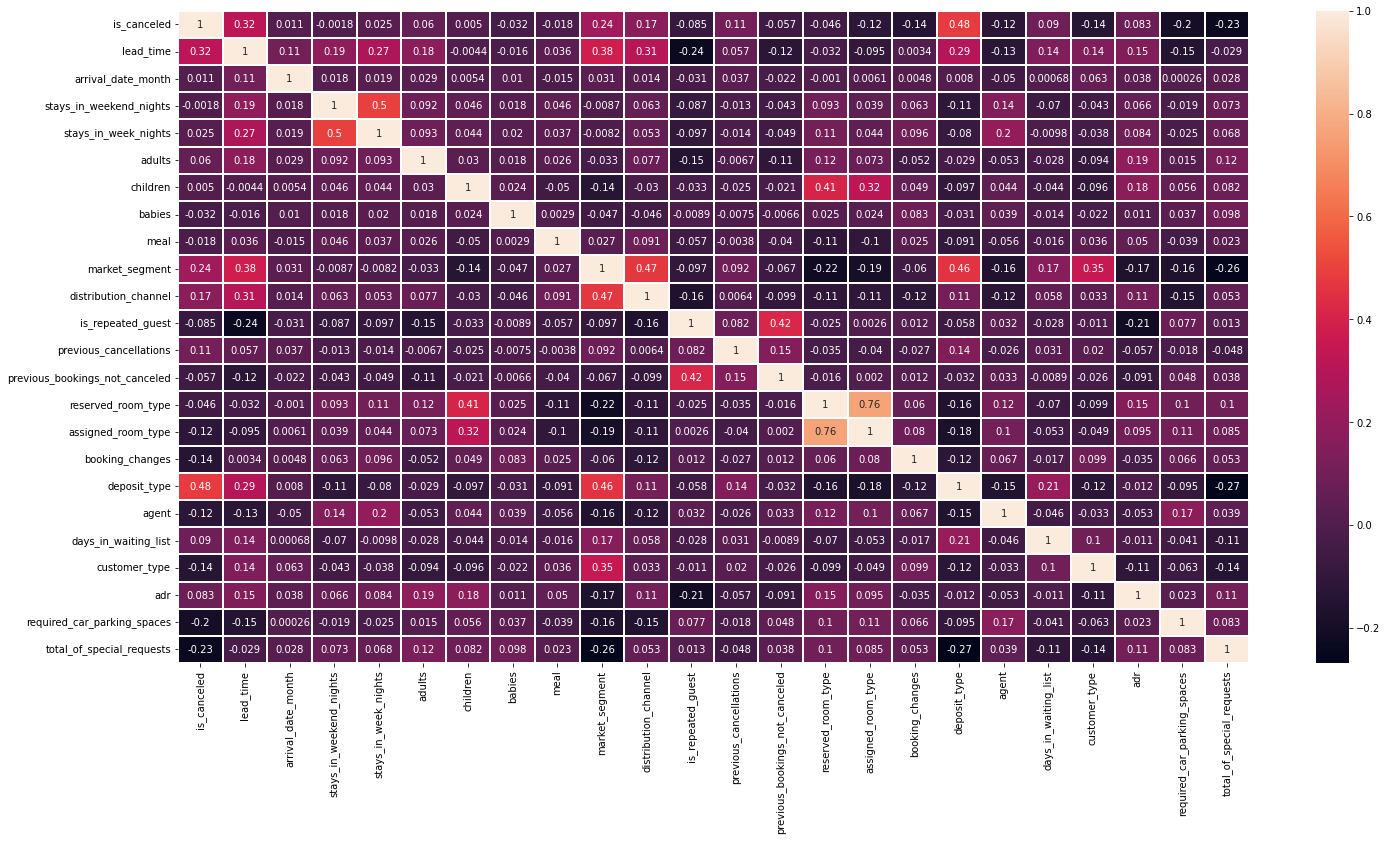

In [25]:
plt.figure(figsize = (24, 12))
sns.heatmap(corr, annot = True, linewidths = 1)
plt.show()

Essas correlações são gerais, aparentemente não há fortes correlações (<=|0.7|), entretanto, há divervar correlações de <=|0.20|, algo que se mostra promissor, alem da maior correlação  com o tipo de depósito.

Aparentemente, o quarto reservado e o quarto que lhe foi atribuido tem uma correlação alta, e entre essas duas features, o 'assigned_room_type' tem uma correlação maior. Se a correlação entre essas duas variaveis fosse maior, seria interessante cortar-la, porem, pensando fora dos dados, uma mudança de quarto de ultima hora pode ser um fator de cancelamento.

### Nan values

Como de praste, é necessário tirar os valores NaN

In [26]:
data.isnull().sum()

hotel                                 0
is_canceled                           0
lead_time                             0
arrival_date_year                     0
arrival_date_month                    0
stays_in_weekend_nights               0
stays_in_week_nights                  0
adults                                0
children                              4
babies                                0
meal                                  0
market_segment                        0
distribution_channel                  0
is_repeated_guest                     0
previous_cancellations                0
previous_bookings_not_canceled        0
reserved_room_type                   12
assigned_room_type                  654
booking_changes                       0
deposit_type                          0
agent                             16340
days_in_waiting_list                  0
customer_type                         0
adr                                   1
required_car_parking_spaces           0


Para as variáveis 'children', como não há apenas 4 registro com nan, pode-se considerar que não há crianças, logo os nan = 0

In [27]:
data['children'] =  data['children'].fillna(0)

para os valores 'reserved_room_type' e 'assigned_room_type', é aferivel que se há um e o outro não, o que existe substituirá o valor nan do outro, infelizmente perdendo a informação de 'pode ser que tenha sido alterado...' porem, não há como ter certeza nessa caso.


In [28]:
num_equals = 0
for index,row in data.iterrows():
  try:
    if row['reserved_room_type'] == row['assigned_room_type']:
      num_equals+=1
  except:
    pass

print(f'Numero de igual correponde a {num_equals/data.shape[0]*100}%')
  


Numero de igual correponde a 87.49560264678784%



Alem do mais, muitos casos permaneceram o mesmo, sem alteração, então não é como se fosse algo muito impactante.
No caso de ambos serem Nan, será assumido que o valor deles é aquele que mais apareceu, que no caso após o encoding é o valor 1.

In [29]:
data['assigned_room_type'].value_counts()

1.0    74053
2.0    25322
3.0     7806
5.0     3751
4.0     2553
0.0     2375
8.0     2163
6.0      712
7.0        1
Name: assigned_room_type, dtype: int64

In [30]:
for index,row in data.iterrows():
  try:
    if np.isnan(row['reserved_room_type']):
      if np.isnan(row['assigned_room_type']):
        data.iloc[index,16] = 1
        data.iloc[index,17] = 1

      else:
        data.iloc[index,16] = data.iloc[index,17]
    
    elif np.isnan(row['assigned_room_type']):
      data.iloc[index,17] = data.iloc[index,16]

  except:
    pass


Por fim, a feature 'agent', com o maior numero de valores nan, segundo o artigo, o valor nan nessa categoria não necessáriamente é um erro de tabelamento, mas sim a ausencia.

Assim, como o caso anterior, para preencher os valores Nan, será usado o seu maior valor (lembrando que essa feature passou por uma operação para diminuir sua variancia)

A feature 'adr' tem apenas um valor faltante, então colocar no valor que mais aparece não seria muito problema

In [31]:
#data['agent'].value_counts()
data['agent'] =  data['agent'].fillna(2.302585)
data['adr']   =  data['adr'].fillna(4.143135)

In [32]:
data.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
dtype: int64

## Separação dos dados

Após analisar o artigo que apresenta os dados, foi levantada a hipótese de que 1 algortimo para hotéis em cidade e Resorts não seja o melhor caminho, visto que:

* Pelos dados vemos que há diferenças como serviços, preços e principalmente, a proporção de cancelamentos por ano (Secção de "Diferenciação" na EDA).
* Após pesquisas online, vemos que blogs e artigos de sites de empresas mostram que são lazeres diferentes, para pessoas diferentes.

Logo, considerando que há dois grupos diferentes, é possivel que seja mais efetivo haverem 2 modelos em vez de um generalista.


In [33]:
City   = data[data['hotel'] == 'City Hotel']

Resort = data[data['hotel'] != 'City Hotel']

Sendo assim, os proximos passos vão ser divididos na analise e modelagem separada entre o Hotel 1 (City Hotel) e o Hotel 2 (Resort Hotel)

## Diferenciação entre Resort Hotel x city Hotel

A primeira diferenciação dos tipos de Hotel é vista na porcentagem de cancelamentos por ano

In [34]:
years = City['arrival_date_year'].unique()

fig1 = go.Figure(data = [
    go.Bar(x=years,
        y=[np.round(a/b*100,2) for a,b in zip(City[City['is_canceled'] == '0']['arrival_date_year'].value_counts(),City['arrival_date_year'].value_counts())],
        text=[np.round(a/b*100,2) for a,b in zip(City[City['is_canceled'] == '0']['arrival_date_year'].value_counts(),City['arrival_date_year'].value_counts())],
        name='Not cancelled percent'),
    go.Bar(x=years,
           y=[np.round(a/b*100,2) for a,b in zip(City[City['is_canceled'] == '1']['arrival_date_year'].value_counts(),City['arrival_date_year'].value_counts())],
           text = [np.round(a/b*100,2) for a,b in zip(City[City['is_canceled'] == '1']['arrival_date_year'].value_counts(),City['arrival_date_year'].value_counts())],
           name='Cancel percent')
])
fig1.update_layout(barmode='stack', title = 'Cancelling percent by year - City Hotel')

fig2 = go.Figure(data = [
    go.Bar(x=years,
        y=[np.round(a/b*100,2) for a,b in zip(Resort[Resort['is_canceled'] == '0']['arrival_date_year'].value_counts(),Resort['arrival_date_year'].value_counts())],
        text=[np.round(a/b*100,2) for a,b in zip(Resort[Resort['is_canceled'] == '0']['arrival_date_year'].value_counts(),Resort['arrival_date_year'].value_counts())],
        name='Not cancelled percent'),
    go.Bar(x=years,
           y=[np.round(a/b*100,2) for a,b in zip(Resort[Resort['is_canceled'] == '1']['arrival_date_year'].value_counts(),Resort['arrival_date_year'].value_counts())],
           text = [np.round(a/b*100,2) for a,b in zip(Resort[Resort['is_canceled'] == '1']['arrival_date_year'].value_counts(),Resort['arrival_date_year'].value_counts())],
           name='Cancel percent')
])
fig2.update_layout(barmode='stack', title = 'Cancelling percent by year - Resort Hotel')


figures_to_html([fig1, fig2], filename = '/content/drive/MyDrive/Hurb/Imagens/Compariosion.html')

Vê-se que a taxa de cancelamento do resorte é de 25-30% nesses 30 anos, e do hotel de cidade é de 40-44% !

Esse efeito pode ser advindo de muitos fatores, mas podemos citar que a diferença principal entre essas duas hotelarias é de quem em um resort, os convidados não necessitam ir a outro lugar para fazer nada, tudo está dentro do próprio resort

Essa fator pode ser visto como "Não haverá tantos imprevistos", diminuindo a taxa de cancelamento de uma viagem planejada

Blogs comentando as diferenças:
* https://www.vacationclubrentals.com/blog/resort-vs-hotel-vacation
* https://www.cataloniahotels.com/en/blog/difference-between-a-hotel-and-resort/
* https://www.beaches.com/blog/resorts-vs-hotels/



In [35]:
City[['adults','children','babies','stays_in_weekend_nights','stays_in_week_nights']].mean()

adults                     1.850977
children                   0.091365
babies                     0.004941
stays_in_weekend_nights    0.795185
stays_in_week_nights       2.182957
dtype: float64

In [36]:
Resort[['adults','children','babies','stays_in_weekend_nights','stays_in_week_nights']].mean()

adults                     1.867149
children                   0.128682
babies                     0.013904
stays_in_weekend_nights    1.189815
stays_in_week_nights       3.128732
dtype: float64

Alem disso, tem tipos de quartos e refeições diferentes.

É seguro levar esses dois datasets como situações separadas que merecem um algoritmo para prever o cancelamento respectivamente.


## Salvando os dados limpos

#City Hotel

##Test/Train

Obs: Não será feita a etapa de validação por não terem sido feitos testes maiores em parametros dos algoritmos, o objetivo foi utilizar a forma básica deles.

In [37]:
City = City.drop(columns=['arrival_date_year'])

X = City.iloc[:,2:]
y = City.iloc[:,1]

Separação de train test val:
* Train - 80%
* Test  - 20%

Train-Test separation 

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

## Modelagem dos dados

Nessa secção, fora feitos diversos treinos para a escolha do algoritmo, os Scores de cada um deles se encontra no final dessa Seção sobre o nome de "Resultados"

vale lembrar que todos os modelos foram testados em sua versão básica, sem o uso de técnicas como cross validation, grid search, pois aumentar o tempo de processamento e complexidade do trabalho foge do escopo do exercício.

Após escolhido o melhor modelo e parametros, essa parte vai estar separada em um código .py, onde os modelos serão efetivamente salvos.

In [39]:
result_dict_city = {}

### Regressão Logistica - Benchmark model

In [40]:
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

acc_LogReg        = accuracy_score(y_test, y_pred_lr)
conf_LogReg       = confusion_matrix(y_test, y_pred_lr)
clf_report_LogReg = classification_report(y_test, y_pred_lr,output_dict= True)
auc_LogReg        = roc_auc_score(y_test, y_pred_lr)

print(f"Accuracy Score of Logistic Regression is : {acc_LogReg}\n")
print(f"Confusion Matrix : {conf_LogReg}\n")
print(f"Classification Report : {clf_report_LogReg}\n")
print(f"Area under Curve Metric : {auc_LogReg}\n")

Accuracy Score of Logistic Regression is : 0.8041724442203454

Confusion Matrix : [[8661  611]
 [2496 4098]]

Classification Report : {'0': {'precision': 0.7762839472976607, 'recall': 0.9341026747195859, 'f1-score': 0.8479122815605268, 'support': 9272}, '1': {'precision': 0.8702484603949883, 'recall': 0.62147406733394, 'f1-score': 0.7251172255153499, 'support': 6594}, 'accuracy': 0.8041724442203454, 'macro avg': {'precision': 0.8232662038463245, 'recall': 0.7777883710267629, 'f1-score': 0.7865147535379383, 'support': 15866}, 'weighted avg': {'precision': 0.8153361343242445, 'recall': 0.8041724442203454, 'f1-score': 0.7968779566165021, 'support': 15866}}

Area under Curve Metric : 0.7777883710267629



In [41]:
result_dict_city['Logistic Regression'] = [
    acc_LogReg,
    clf_report_LogReg['weighted avg']['precision'],
    clf_report_LogReg['weighted avg']['recall'],
    clf_report_LogReg['weighted avg']['f1-score'],
    auc_LogReg
]

### SVM

In [42]:
svm = SVC()
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

acc_svm        = accuracy_score(y_test, y_pred_svm)
conf_svm       = confusion_matrix(y_test, y_pred_svm)
clf_report_svm = classification_report(y_test, y_pred_svm,output_dict= True)
auc_svm        = roc_auc_score(y_test, y_pred_svm)

print(f"Accuracy Score of svm is : {acc_svm}/n")
print(f"Confusion Matrix : n{conf_svm}/n")
print(f"Classification Report : n{clf_report_svm}/n")
print(f"Area under Curve Metric : {auc_svm}\n")

Accuracy Score of svm is : 0.8166519601663935/n
Confusion Matrix : n[[8678  594]
 [2315 4279]]/n
Classification Report : n{'0': {'precision': 0.7894114436459565, 'recall': 0.9359361518550474, 'f1-score': 0.856452010856156, 'support': 9272}, '1': {'precision': 0.8781038374717833, 'recall': 0.648923263572945, 'f1-score': 0.7463155140838929, 'support': 6594}, 'accuracy': 0.8166519601663935, 'macro avg': {'precision': 0.8337576405588699, 'recall': 0.7924297077139962, 'f1-score': 0.8013837624700244, 'support': 15866}, 'weighted avg': {'precision': 0.8262725078642535, 'recall': 0.8166519601663935, 'f1-score': 0.8106786552708602, 'support': 15866}}/n
Area under Curve Metric : 0.7924297077139963



In [43]:
result_dict_city['Support Vector Machine'] = [
    acc_svm,
    clf_report_svm['weighted avg']['precision'],
    clf_report_svm['weighted avg']['recall'],
    clf_report_svm['weighted avg']['f1-score'],
    auc_svm
]

### Rede Neural

In [44]:

NNet = Sequential()
NNet.add(Dense(units = 16, activation = 'relu', 
                    kernel_initializer = 'random_uniform', 
                    input_dim = 23))
NNet.add(Dense(units = 8, activation = 'relu', 
                    kernel_initializer = 'random_uniform'))
NNet.add(Dense(units = 4, activation = 'relu', 
                    kernel_initializer = 'random_uniform'))
NNet.add(Dense(units = 1, activation = 'sigmoid'))
NNet.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                  metrics = ['binary_accuracy'])

In [45]:
NNet.fit(X_train, y_train, epochs = 50, verbose = 0)

In [46]:
y_pred_NNet = NNet.predict(X_test)
y_pred_NNet = (y_pred_NNet > 0.5)

acc_NNet        = accuracy_score(y_test, y_pred_NNet)
conf_NNet       = confusion_matrix(y_test, y_pred_NNet)
clf_report_NNet = classification_report(y_test, y_pred_NNet,output_dict= True)
auc_NNet        = roc_auc_score(y_test, y_pred_NNet)

print(f"Accuracy Score of NNet is : {acc_NNet}/n")
print(f"Confusion Matrix : n{conf_NNet}/n")
print(f"Classification Report : n{clf_report_NNet}/n")
print(f"Area under Curve Metric : {auc_NNet}\n")



496/496 [==============================] - 1s 1ms/step
Accuracy Score of NNet is : 0.8218832724064036/n
Confusion Matrix : n[[8459  813]
 [2013 4581]]/n
Classification Report : n{'0': {'precision': 0.8077731092436975, 'recall': 0.9123166522864539, 'f1-score': 0.8568679092382496, 'support': 9272}, '1': {'precision': 0.8492769744160178, 'recall': 0.694722474977252, 'f1-score': 0.7642642642642642, 'support': 6594}, 'accuracy': 0.8218832724064036, 'macro avg': {'precision': 0.8285250418298576, 'recall': 0.803519563631853, 'f1-score': 0.810566086751257, 'support': 15866}, 'weighted avg': {'precision': 0.8250223520866496, 'recall': 0.8218832724064036, 'f1-score': 0.8183813067575701, 'support': 15866}}/n
Area under Curve Metric : 0.803519563631853



In [47]:
result_dict_city['Neural Network'] = [
    acc_NNet,
    clf_report_NNet['weighted avg']['precision'],
    clf_report_NNet['weighted avg']['recall'],
    clf_report_NNet['weighted avg']['f1-score'],
    auc_NNet
]

### Adaboost

In [48]:
adab = AdaBoostClassifier()
adab.fit(X_train, y_train)

y_pred_adab = adab.predict(X_test)

acc_adab        = accuracy_score(y_test, y_pred_adab)
conf_adab       = confusion_matrix(y_test, y_pred_adab)
clf_report_adab = classification_report(y_test, y_pred_adab,output_dict= True)
auc_adab        = roc_auc_score(y_test, y_pred_adab)

print(f"Accuracy Score of adab is : {acc_adab}/n")
print(f"Confusion Matrix : n{conf_adab}/n")
print(f"Classification Report : n{clf_report_adab}/n")
print(f"Area under Curve Metric : {auc_adab}\n")

Accuracy Score of adab is : 0.8191100466406152/n
Confusion Matrix : n[[8615  657]
 [2213 4381]]/n
Classification Report : n{'0': {'precision': 0.7956224602881419, 'recall': 0.9291415012942191, 'f1-score': 0.8572139303482585, 'support': 9272}, '1': {'precision': 0.869591107582374, 'recall': 0.6643918713982409, 'f1-score': 0.7532668500687758, 'support': 6594}, 'accuracy': 0.8191100466406152, 'macro avg': {'precision': 0.832606783935258, 'recall': 0.7967666863462299, 'f1-score': 0.8052403902085172, 'support': 15866}, 'weighted avg': {'precision': 0.8263642515561469, 'recall': 0.8191100466406152, 'f1-score': 0.8140129315229145, 'support': 15866}}/n
Area under Curve Metric : 0.7967666863462299



In [49]:
result_dict_city['AdaBoost'] = [
    acc_adab,
    clf_report_adab['weighted avg']['precision'],
    clf_report_adab['weighted avg']['recall'],
    clf_report_adab['weighted avg']['f1-score'],
    auc_adab
]

### KNN

In [50]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

acc_knn        = accuracy_score(y_test, y_pred_knn)
conf_knn       = confusion_matrix(y_test, y_pred_knn)
clf_report_knn = classification_report(y_test, y_pred_knn,output_dict= True)
auc_knn        = roc_auc_score(y_test, y_pred_knn)

print(f"Accuracy Score of KNN is : {acc_knn}/n")
print(f"Confusion Matrix : n{conf_knn}/n")
print(f"Classification Report : n{clf_report_knn}/n")
print(f"Area under Curve Metric : {auc_knn}\n")

Accuracy Score of KNN is : 0.8256019160468927/n
Confusion Matrix : n[[8127 1145]
 [1622 4972]]/n
Classification Report : n{'0': {'precision': 0.8336239614319417, 'recall': 0.8765099223468508, 'f1-score': 0.8545292045633773, 'support': 9272}, '1': {'precision': 0.8128167402321399, 'recall': 0.754018804974219, 'f1-score': 0.7823145307214223, 'support': 6594}, 'accuracy': 0.8256019160468927, 'macro avg': {'precision': 0.8232203508320408, 'recall': 0.8152643636605349, 'f1-score': 0.8184218676423998, 'support': 15866}, 'weighted avg': {'precision': 0.8249763617476172, 'recall': 0.8256019160468927, 'f1-score': 0.8245163746557855, 'support': 15866}}/n
Area under Curve Metric : 0.8152643636605349



In [51]:
result_dict_city['KNN'] = [
    acc_knn,
    clf_report_knn['weighted avg']['precision'],
    clf_report_knn['weighted avg']['recall'],
    clf_report_knn['weighted avg']['f1-score'],
    auc_knn
]

### Decision tree

In [52]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

y_pred_dtc = dtc.predict(X_test)

acc_dtc        = accuracy_score(y_test, y_pred_dtc)
conf_dtc       = confusion_matrix(y_test, y_pred_dtc)
clf_report_dtc = classification_report(y_test, y_pred_dtc,output_dict= True)
auc_dtc        = roc_auc_score(y_test, y_pred_dtc)

print(f"Accuracy Score of Decision Tree is : {acc_dtc}c")
print(f"Confusion Matrix : n{conf_dtc}\n")
print(f"Classification Report : n{clf_report_dtc}\n")
print(f"Area under Curve Metric : {auc_dtc}\n")

Accuracy Score of Decision Tree is : 0.8267364174965335c
Confusion Matrix : n[[7810 1462]
 [1287 5307]]

Classification Report : n{'0': {'precision': 0.8585247883917775, 'recall': 0.842320966350302, 'f1-score': 0.8503456911100223, 'support': 9272}, '1': {'precision': 0.7840153641601418, 'recall': 0.8048225659690628, 'f1-score': 0.7942827209458954, 'support': 6594}, 'accuracy': 0.8267364174965335, 'macro avg': {'precision': 0.8212700762759597, 'recall': 0.8235717661596824, 'f1-score': 0.8223142060279589, 'support': 15866}, 'weighted avg': {'precision': 0.8275582471473929, 'recall': 0.8267364174965335, 'f1-score': 0.8270456012787949, 'support': 15866}}

Area under Curve Metric : 0.8235717661596824



In [53]:
result_dict_city['Decision Tree'] = [
    acc_dtc,
    clf_report_dtc['weighted avg']['precision'],
    clf_report_dtc['weighted avg']['recall'],
    clf_report_dtc['weighted avg']['f1-score'],
    auc_dtc
]

### random Forest

In [54]:
rdc = RandomForestClassifier()
rdc.fit(X_train, y_train)

y_pred_rdc = rdc.predict(X_test)

acc_rdc        = accuracy_score(y_test, y_pred_rdc)
conf_rdc       = confusion_matrix(y_test, y_pred_rdc)
clf_report_rdc = classification_report(y_test, y_pred_rdc,output_dict= True)
auc_rdc        = roc_auc_score(y_test, y_pred_rdc)

print(f"Accuracy Score of Decision Tree is : {acc_rdc}c")
print(f"Confusion Matrix : n{conf_rdc}\n")
print(f"Classification Report : n{clf_report_rdc}\n")
print(f"Area under Curve Metric : {auc_rdc}\n")

Accuracy Score of Decision Tree is : 0.8694693054330014c
Confusion Matrix : n[[8528  744]
 [1327 5267]]

Classification Report : n{'0': {'precision': 0.8653475393201421, 'recall': 0.9197584124245038, 'f1-score': 0.8917237413080985, 'support': 9272}, '1': {'precision': 0.8762269173182499, 'recall': 0.7987564452532605, 'f1-score': 0.8357001190003966, 'support': 6594}, 'accuracy': 0.8694693054330014, 'macro avg': {'precision': 0.870787228319196, 'recall': 0.8592574288388821, 'f1-score': 0.8637119301542475, 'support': 15866}, 'weighted avg': {'precision': 0.8698690708037878, 'recall': 0.8694693054330014, 'f1-score': 0.8684400046701944, 'support': 15866}}

Area under Curve Metric : 0.8592574288388822



In [55]:
result_dict_city['Random forest'] = [
    acc_rdc,
    clf_report_rdc['weighted avg']['precision'],
    clf_report_rdc['weighted avg']['recall'],
    clf_report_rdc['weighted avg']['f1-score'],
    auc_rdc
]

# Resort Hotel

##Test/Train

Obs: Não será feita a etapa de validação por não terem sido feitos testes maiores em parametros dos algoritmos, o objetivo foi utilizar a forma básica deles.

In [56]:
Resort = Resort.drop(columns=['arrival_date_year'])

X = Resort.iloc[:,2:]
y = Resort.iloc[:,1]

Separação de train test val:
* Train - 80%
* Test  - 20%

Train-Test separation 

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

## Modelagem dos dados

Nessa secção, fora feitos diversos treinos para a escolha do algoritmo, os Scores de cada um deles se encontra no final dessa Seção sobre o nome de "Resultados"

vale lembrar que todos os modelos foram testados em sua versão básica, sem o uso de técnicas como cross validation, grid search, pois aumentar o tempo de processamento e complexidade do trabalho foge do escopo do exercício.

Após escolhido o melhor modelo e parametros, essa parte vai estar separada em um código .py, onde os modelos serão efetivamente salvos.

In [58]:
result_dict_resort = {}

### Regressão Logistica - Benchmark model

In [59]:
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

acc_LogReg        = accuracy_score(y_test, y_pred_lr)
conf_LogReg       = confusion_matrix(y_test, y_pred_lr)
clf_report_LogReg = classification_report(y_test, y_pred_lr,output_dict= True)
auc_LogReg        = roc_auc_score(y_test, y_pred_lr)

print(f"Accuracy Score of Logistic Regression is : {acc_LogReg}\n")
print(f"Confusion Matrix : {conf_LogReg}\n")
print(f"Classification Report : {clf_report_LogReg}\n")
print(f"Area under Curve Metric : {auc_LogReg}\n")

Accuracy Score of Logistic Regression is : 0.8050424363454818

Confusion Matrix : [[5443  363]
 [1199 1007]]

Classification Report : {'0': {'precision': 0.819482083709726, 'recall': 0.9374784705477093, 'f1-score': 0.8745179948586118, 'support': 5806}, '1': {'precision': 0.7350364963503649, 'recall': 0.45648232094288305, 'f1-score': 0.5631991051454138, 'support': 2206}, 'accuracy': 0.8050424363454818, 'macro avg': {'precision': 0.7772592900300455, 'recall': 0.6969803957452961, 'f1-score': 0.7188585500020128, 'support': 8012}, 'weighted avg': {'precision': 0.7962310894867166, 'recall': 0.8050424363454818, 'f1-score': 0.7888003874313384, 'support': 8012}}

Area under Curve Metric : 0.6969803957452961



In [60]:
result_dict_resort['Logistic Regression'] = [
    acc_LogReg,
    clf_report_LogReg['weighted avg']['precision'],
    clf_report_LogReg['weighted avg']['recall'],
    clf_report_LogReg['weighted avg']['f1-score'],
    auc_LogReg
]

### SVM

In [61]:
svm = SVC()
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

acc_svm        = accuracy_score(y_test, y_pred_svm)
conf_svm       = confusion_matrix(y_test, y_pred_svm)
clf_report_svm = classification_report(y_test, y_pred_svm,output_dict= True)
auc_svm        = roc_auc_score(y_test, y_pred_svm)

print(f"Accuracy Score of svm is : {acc_svm}/n")
print(f"Confusion Matrix : n{conf_svm}/n")
print(f"Classification Report : n{clf_report_svm}/n")
print(f"Area under Curve Metric : {auc_svm}\n")

Accuracy Score of svm is : 0.8170244633050424/n
Confusion Matrix : n[[5561  245]
 [1221  985]]/n
Classification Report : n{'0': {'precision': 0.8199646122087879, 'recall': 0.9578022735101619, 'f1-score': 0.8835398792500793, 'support': 5806}, '1': {'precision': 0.8008130081300813, 'recall': 0.4465095194922937, 'f1-score': 0.5733410942956927, 'support': 2206}, 'accuracy': 0.8170244633050424, 'macro avg': {'precision': 0.8103888101694345, 'recall': 0.7021558965012278, 'f1-score': 0.728440486772886, 'support': 8012}, 'weighted avg': {'precision': 0.8146914671017451, 'recall': 0.8170244633050424, 'f1-score': 0.7981306781006313, 'support': 8012}}/n
Area under Curve Metric : 0.7021558965012278



In [62]:
result_dict_resort['Support Vector Machine'] = [
    acc_svm,
    clf_report_svm['weighted avg']['precision'],
    clf_report_svm['weighted avg']['recall'],
    clf_report_svm['weighted avg']['f1-score'],
    auc_svm
]

### Rede Neural

In [63]:

NNet = Sequential()
NNet.add(Dense(units = 16, activation = 'relu', 
                    kernel_initializer = 'random_uniform', 
                    input_dim = 23))
NNet.add(Dense(units = 8, activation = 'relu', 
                    kernel_initializer = 'random_uniform'))
NNet.add(Dense(units = 4, activation = 'relu', 
                    kernel_initializer = 'random_uniform'))
NNet.add(Dense(units = 1, activation = 'sigmoid'))
NNet.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                  metrics = ['binary_accuracy'])

In [64]:
NNet.fit(X_train, y_train, epochs = 50, verbose = 0)

In [65]:
y_pred_NNet = NNet.predict(X_test)
y_pred_NNet = (y_pred_NNet > 0.5)

acc_NNet        = accuracy_score(y_test, y_pred_NNet)
conf_NNet       = confusion_matrix(y_test, y_pred_NNet)
clf_report_NNet = classification_report(y_test, y_pred_NNet,output_dict= True)
auc_NNet        = roc_auc_score(y_test, y_pred_NNet)

print(f"Accuracy Score of NNet is : {acc_NNet}/n")
print(f"Confusion Matrix : n{conf_NNet}/n")
print(f"Classification Report : n{clf_report_NNet}/n")
print(f"Area under Curve Metric : {auc_NNet}\n")



251/251 [==============================] - 0s 1ms/step
Accuracy Score of NNet is : 0.8296305541687469/n
Confusion Matrix : n[[5537  269]
 [1096 1110]]/n
Classification Report : n{'0': {'precision': 0.8347655661088497, 'recall': 0.953668618670341, 'f1-score': 0.8902644907146877, 'support': 5806}, '1': {'precision': 0.8049311094996374, 'recall': 0.5031731640979148, 'f1-score': 0.6192468619246861, 'support': 2206}, 'accuracy': 0.8296305541687469, 'macro avg': {'precision': 0.8198483378042436, 'recall': 0.7284208913841279, 'f1-score': 0.754755676319687, 'support': 8012}, 'weighted avg': {'precision': 0.8265510364932827, 'recall': 0.8296305541687469, 'f1-score': 0.8156433113448994, 'support': 8012}}/n
Area under Curve Metric : 0.7284208913841279



In [66]:
result_dict_resort['Neural Network'] = [
    acc_NNet,
    clf_report_NNet['weighted avg']['precision'],
    clf_report_NNet['weighted avg']['recall'],
    clf_report_NNet['weighted avg']['f1-score'],
    auc_NNet
]

### Adaboost

In [67]:
adab = AdaBoostClassifier()
adab.fit(X_train, y_train)

y_pred_adab = adab.predict(X_test)

acc_adab        = accuracy_score(y_test, y_pred_adab)
conf_adab       = confusion_matrix(y_test, y_pred_adab)
clf_report_adab = classification_report(y_test, y_pred_adab,output_dict= True)
auc_adab        = roc_auc_score(y_test, y_pred_adab)

print(f"Accuracy Score of adab is : {acc_adab}/n")
print(f"Confusion Matrix : n{conf_adab}/n")
print(f"Classification Report : n{clf_report_adab}/n")
print(f"Area under Curve Metric : {auc_adab}\n")

Accuracy Score of adab is : 0.8260109835247129/n
Confusion Matrix : n[[5424  382]
 [1012 1194]]/n
Classification Report : n{'0': {'precision': 0.8427594779366065, 'recall': 0.9342059937995177, 'f1-score': 0.8861297173664434, 'support': 5806}, '1': {'precision': 0.7576142131979695, 'recall': 0.5412511332728921, 'f1-score': 0.6314119513484929, 'support': 2206}, 'accuracy': 0.8260109835247129, 'macro avg': {'precision': 0.800186845567288, 'recall': 0.737728563536205, 'f1-score': 0.7587708343574682, 'support': 8012}, 'weighted avg': {'precision': 0.819315836646862, 'recall': 0.8260109835247129, 'f1-score': 0.8159964932232084, 'support': 8012}}/n
Area under Curve Metric : 0.737728563536205



In [68]:
result_dict_resort['AdaBoost'] = [
    acc_adab,
    clf_report_adab['weighted avg']['precision'],
    clf_report_adab['weighted avg']['recall'],
    clf_report_adab['weighted avg']['f1-score'],
    auc_adab
]

### KNN

In [69]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

acc_knn        = accuracy_score(y_test, y_pred_knn)
conf_knn       = confusion_matrix(y_test, y_pred_knn)
clf_report_knn = classification_report(y_test, y_pred_knn,output_dict= True)
auc_knn        = roc_auc_score(y_test, y_pred_knn)

print(f"Accuracy Score of KNN is : {acc_knn}/n")
print(f"Confusion Matrix : n{conf_knn}/n")
print(f"Classification Report : n{clf_report_knn}/n")
print(f"Area under Curve Metric : {auc_knn}\n")

Accuracy Score of KNN is : 0.815152271592611/n
Confusion Matrix : n[[5161  645]
 [ 836 1370]]/n
Classification Report : n{'0': {'precision': 0.8605969651492413, 'recall': 0.888908026179814, 'f1-score': 0.8745234262475643, 'support': 5806}, '1': {'precision': 0.6799007444168734, 'recall': 0.6210335448776065, 'f1-score': 0.6491352760009477, 'support': 2206}, 'accuracy': 0.815152271592611, 'macro avg': {'precision': 0.7702488547830574, 'recall': 0.7549707855287102, 'f1-score': 0.761829351124256, 'support': 8012}, 'weighted avg': {'precision': 0.8108446108137941, 'recall': 0.815152271592611, 'f1-score': 0.8124657303608898, 'support': 8012}}/n
Area under Curve Metric : 0.7549707855287102



In [70]:
result_dict_resort['KNN'] = [
    acc_knn,
    clf_report_knn['weighted avg']['precision'],
    clf_report_knn['weighted avg']['recall'],
    clf_report_knn['weighted avg']['f1-score'],
    auc_knn
]

### Decision tree

In [71]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

y_pred_dtc = dtc.predict(X_test)

acc_dtc        = accuracy_score(y_test, y_pred_dtc)
conf_dtc       = confusion_matrix(y_test, y_pred_dtc)
clf_report_dtc = classification_report(y_test, y_pred_dtc,output_dict= True)
auc_dtc        = roc_auc_score(y_test, y_pred_dtc)

print(f"Accuracy Score of Decision Tree is : {acc_dtc}c")
print(f"Confusion Matrix : n{conf_dtc}\n")
print(f"Classification Report : n{clf_report_dtc}\n")
print(f"Area under Curve Metric : {auc_dtc}\n")

Accuracy Score of Decision Tree is : 0.8230154767848228c
Confusion Matrix : n[[5081  725]
 [ 693 1513]]

Classification Report : n{'0': {'precision': 0.8799792171804641, 'recall': 0.8751291767137444, 'f1-score': 0.8775474956822107, 'support': 5806}, '1': {'precision': 0.6760500446827524, 'recall': 0.685856754306437, 'f1-score': 0.680918091809181, 'support': 2206}, 'accuracy': 0.8230154767848228, 'macro avg': {'precision': 0.7780146309316083, 'recall': 0.7804929655100907, 'f1-score': 0.7792327937456958, 'support': 8012}, 'weighted avg': {'precision': 0.8238299717323921, 'recall': 0.8230154767848228, 'f1-score': 0.8234081465878643, 'support': 8012}}

Area under Curve Metric : 0.7804929655100907



In [72]:
result_dict_resort['Decision Tree'] = [
    acc_dtc,
    clf_report_dtc['weighted avg']['precision'],
    clf_report_dtc['weighted avg']['recall'],
    clf_report_dtc['weighted avg']['f1-score'],
    auc_dtc
]

### random Forest

In [73]:
rdc = RandomForestClassifier()
rdc.fit(X_train, y_train)

y_pred_rdc = rdc.predict(X_test)

acc_rdc        = accuracy_score(y_test, y_pred_rdc)
conf_rdc       = confusion_matrix(y_test, y_pred_rdc)
clf_report_rdc = classification_report(y_test, y_pred_rdc,output_dict= True)
auc_rdc        = roc_auc_score(y_test, y_pred_rdc)

print(f"Accuracy Score of Decision Tree is : {acc_rdc}c")
print(f"Confusion Matrix : n{conf_rdc}\n")
print(f"Classification Report : n{clf_report_rdc}\n")
print(f"Area under Curve Metric : {auc_rdc}\n")

Accuracy Score of Decision Tree is : 0.8681977034448327c
Confusion Matrix : n[[5452  354]
 [ 702 1504]]

Classification Report : n{'0': {'precision': 0.8859278518037049, 'recall': 0.9390285911126421, 'f1-score': 0.9117056856187291, 'support': 5806}, '1': {'precision': 0.8094725511302476, 'recall': 0.6817769718948323, 'f1-score': 0.7401574803149608, 'support': 2206}, 'accuracy': 0.8681977034448327, 'macro avg': {'precision': 0.8477002014669763, 'recall': 0.8104027815037372, 'f1-score': 0.825931582966845, 'support': 8012}, 'weighted avg': {'precision': 0.8648768791020515, 'recall': 0.8681977034448327, 'f1-score': 0.8644721183571074, 'support': 8012}}

Area under Curve Metric : 0.8104027815037372



In [74]:
result_dict_resort['Random forest'] = [
    acc_rdc,
    clf_report_rdc['weighted avg']['precision'],
    clf_report_rdc['weighted avg']['recall'],
    clf_report_rdc['weighted avg']['f1-score'],
    auc_rdc
]

# Resultados

Agora as resultados finais para os dois algoritmos

Resort:

In [75]:
result_df_resort = pd.DataFrame.from_dict(result_dict_resort, orient='index',
                                   columns=['Accuracy', 'Precision', 
                                            'Recall', 'f1-scora','Auc'])

result_df_resort.style.highlight_max(color = 'green', axis = 0)

,Accuracy,Precision,Recall,f1-scora,Auc
Logistic Regression,0.805042,0.796231,0.805042,0.788800,0.696980
Support Vector Machine,0.817024,0.814691,0.817024,0.798131,0.702156
Neural Network,0.829631,0.826551,0.829631,0.815643,0.728421
AdaBoost,0.826011,0.819316,0.826011,0.815996,0.737729
KNN,0.815152,0.810845,0.815152,0.812466,0.754971
Decision Tree,0.823015,0.823830,0.823015,0.823408,0.780493
Random forest,0.868198,0.864877,0.868198,0.864472,0.810403


City:

In [76]:
result_df_city = pd.DataFrame.from_dict(result_dict_city, orient='index',
                                   columns=['Accuracy', 'Precision', 
                                            'Recall', 'f1-scora','Auc'])

result_df_city.style.highlight_max(color = 'green', axis = 0)

,Accuracy,Precision,Recall,f1-scora,Auc
Logistic Regression,0.804172,0.815336,0.804172,0.796878,0.777788
Support Vector Machine,0.816652,0.826273,0.816652,0.810679,0.792430
Neural Network,0.821883,0.825022,0.821883,0.818381,0.803520
AdaBoost,0.819110,0.826364,0.819110,0.814013,0.796767
KNN,0.825602,0.824976,0.825602,0.824516,0.815264
Decision Tree,0.826736,0.827558,0.826736,0.827046,0.823572
Random forest,0.869469,0.869869,0.869469,0.868440,0.859257


--------------------------------------------------------------------------------
Pelos resultados, é possivel perceber que para ambos os datasets, o algoritmo de Random forest se saiu melhor, principalmente em sua precisão e recall , ter uma acurácia é bom, porem prever corretamente os dados é o essencial
--------------------------------------------------------------------------------

Esses dois resultados serão salvos e colocados em scripts separados para serem colocados na etapa de Deploy.
--------------------------------------------------------------------------------
